In [17]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import shap, os
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [22]:
# Get the current directory
current_directory = os.getcwd()
all_data = pd.DataFrame()
# Iterate over files in the current directory
for filename in os.listdir(current_directory):
    if filename.endswith('.json'):
        file_path = os.path.join(current_directory, filename)

        with open(file_path, 'r') as json_file:
            data = json.load(json_file)
            
            # Now 'data' contains the contents of the JSON file
            print(f'Loaded data from {filename}:')
            # Create a DataFrame from the list of JSON objects
            df = pd.DataFrame(data)
            # Append the data_df to the combined_data
            all_data = pd.concat([all_data, df], ignore_index=True)

print(all_data)

Loaded data from game_2020.json:
Loaded data from game_2021.json:
Loaded data from game_2022.json:
Loaded data from game_2023.json:
                   teamId       esportsGameId  inhibKill  towerKill  \
0      102747101565183056  104174613333795054        1.0   0.727273   
1      102747101565183056  104174613333795054        0.0   0.272727   
2       98926509885559666  104174992718947482        1.0   1.000000   
3       98926509885559666  104174992718947482        0.0   0.000000   
4      103461966971048042  104174601835007646        1.0   0.909091   
...                   ...                 ...        ...        ...   
47407  109642680932009857  110425082379044738        0.0   0.090909   
47408  103461966965149786  109919226378726247        1.0   0.900000   
47409  103461966965149786  109919226378726247        0.0   0.100000   
47410  107700199633958891  110847390580148377        1.0   0.714286   
47411  107700199633958891  110847390580148377        0.0   0.285714   

       baronKil

In [23]:
# x is all columns except year, team_id and esports_id
# y is the outcome column
X = all_data.drop(['outcome', 'teamId', 'esportsGameId', 'leagueId', 'year'], axis=1)
y = all_data['outcome']


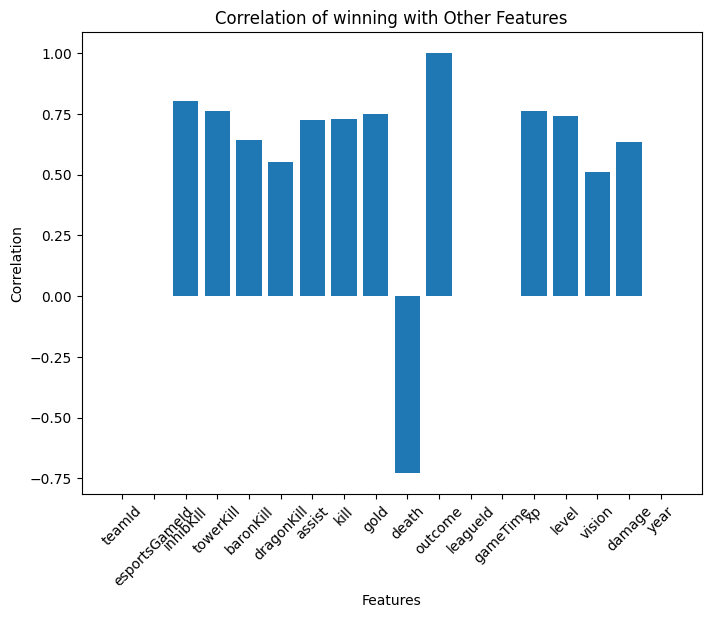

In [24]:
# Calculate the correlation between X and Y features
correlations = all_data.corr()['outcome']

# Create a bar chart to visualize the correlations
plt.figure(figsize=(8, 6))
plt.bar(correlations.index, correlations)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title(f'Correlation of winning with Other Features')
plt.xticks(rotation=45)
plt.show()

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
def evaluate_model(y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Print the recall score and sensitivity
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    recall = cm[1][1] / (cm[1][1] + cm[1][0])
    print("Recall:", recall)
    precision = cm[1][1] / (cm[1][1] + cm[0][1])
    print("Precision:", precision)


In [27]:
def logistic_reg():
    # Create and fit a Logistic Regression model
    model = LogisticRegression()

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    evaluate_model(y_pred)

    return model

In [28]:
def random_forests():
    # Create the Random Forest Classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust hyperparameters as needed

    # Train the model on the training data
    rf_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = rf_model.predict(X_test)

    # Evaluate the model's performance
    evaluate_model(y_pred)

    return rf_model

In [29]:
def decision_tree():
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)

    # Evaluate the model's performance on the testing data
    y_pred = dt_model.predict(X_test)
    evaluate_model(y_pred)

    return dt_model


In [37]:
def xgb():
    # Create a Gradient Boosting classifier (XGBoost)
    xgb_classifier = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, objective='binary:logistic',enable_categorical=True)

    # Train the XGBoost classifier
    xgb_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = xgb_classifier.predict(X_test)

    # Evaluate the model's performance
    evaluate_model(y_pred)

    return xgb_classifier

In [31]:
def svm():
    # Create an SVM classifier (you can choose different kernels and parameters)
    svm_classifier = SVC(kernel='linear', C=1.0)

    # Train the SVM classifier
    svm_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = svm_classifier.predict(X_test)

    # Evaluate the model's performance
    evaluate_model(y_pred)

In [32]:
def feat_imp(model):
    # Get feature importances
    feature_importances = model.feature_importances_

    # Assuming you have a list of feature names or column names
    feature_names = list(X.columns)

    # Create a DataFrame to display feature names and their importances
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

    # Sort the DataFrame by feature importance in descending order
    importances_df = importances_df.sort_values(by='Importance', ascending=False)

    # Print or visualize the feature importances
    print(importances_df)

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(importances_df['Feature'], importances_df['Importance'])
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importances')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

    # Show the chart
    plt.tight_layout()
    plt.show()


Accuracy: 0.9152167035748181
[[4345  399]
 [ 405 4334]]
Recall: 0.9145389322641908
Precision: 0.9156982886118741
       Feature  Importance
6         gold    0.257582
1    towerKill    0.149019
9           xp    0.125229
10       level    0.112976
0    inhibKill    0.087761
7        death    0.066313
5         kill    0.042625
4       assist    0.037479
11      vision    0.033818
12      damage    0.033510
8     gameTime    0.033328
3   dragonKill    0.015012
2    baronKill    0.005348


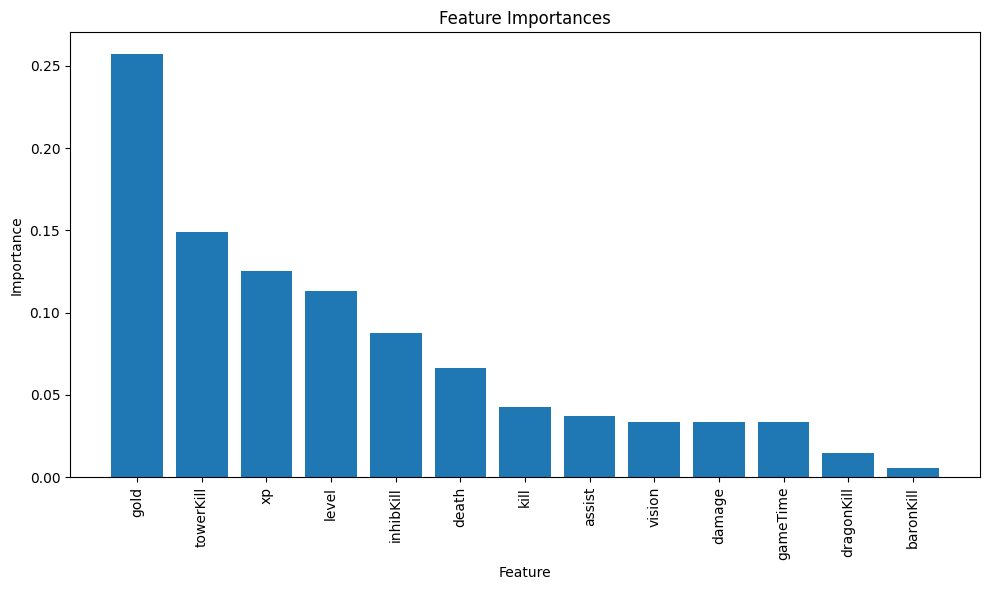

In [33]:
model = random_forests()
feat_imp(model)

Accuracy: 0.8281134662026784
[[3919  825]
 [ 805 3934]]
Recall: 0.8301329394387001
Precision: 0.8266442529943265
       Feature  Importance
6         gold    0.689555
9           xp    0.044334
11      vision    0.041268
8     gameTime    0.036656
12      damage    0.032950
4       assist    0.032148
1    towerKill    0.029092
10       level    0.022731
0    inhibKill    0.018760
7        death    0.017748
5         kill    0.015654
3   dragonKill    0.013862
2    baronKill    0.005244


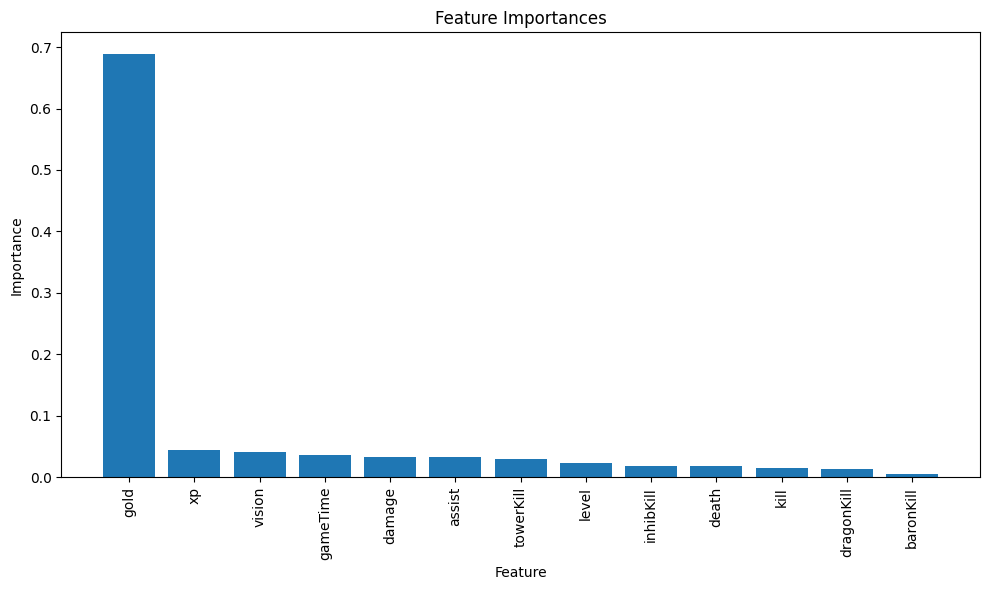

In [34]:
model = decision_tree()
feat_imp(model)

In [35]:
model = logistic_reg()
# Access the coefficients
coefficients = model.coef_
print(coefficients)

Accuracy: 0.5002636296530634
[[4744    0]
 [4739    0]]
Recall: 0.0
Precision: nan
[[ 1.11852844e-09  6.83408699e-10  8.61326965e-10  4.88527145e-10
   5.15239023e-10  4.79549618e-10  1.11676041e-10 -4.76436804e-10
  -3.49792940e-10  9.73253657e-11  5.23442880e-11  7.73565387e-11
   8.61489020e-11]]


invalid value encountered in scalar divide


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecat

Accuracy: 0.91426763682379
[[4341  403]
 [ 410 4329]]
Recall: 0.9134838573538722
Precision: 0.9148351648351648
       Feature  Importance
6         gold    0.750634
1    towerKill    0.164310
9           xp    0.028637
0    inhibKill    0.023804
10       level    0.010698
2    baronKill    0.004176
4       assist    0.003560
8     gameTime    0.003185
3   dragonKill    0.002558
11      vision    0.002361
12      damage    0.002303
5         kill    0.002122
7        death    0.001652


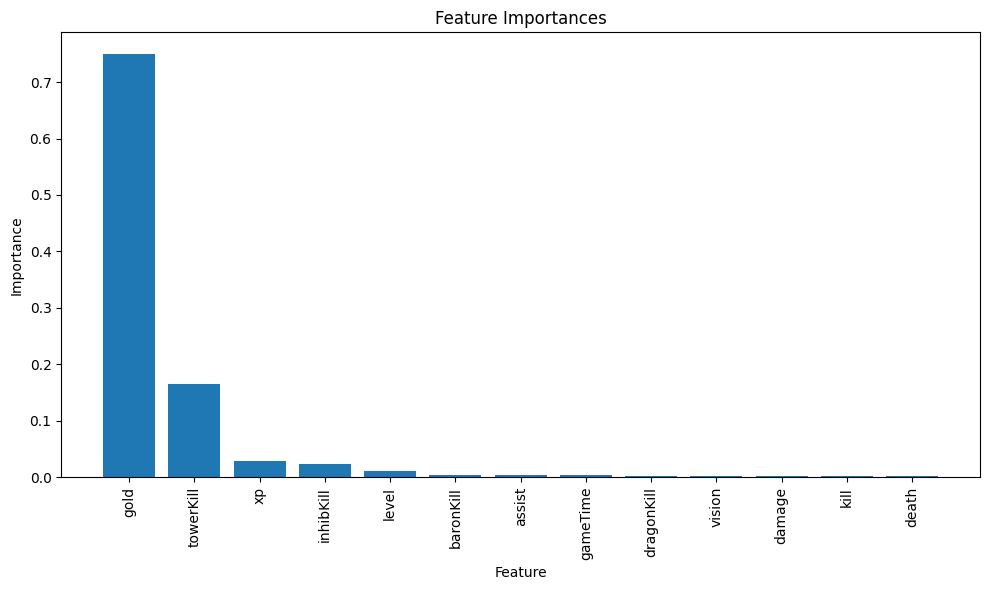

In [38]:
model = xgb()
feat_imp(model)

In [ ]:
# explainer = shap.Explainer(model)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test, feature_names=feature_names)